# 11. 종양 탐지를 위한 분류 모델 훈련
## 11.1 기본 모델과 훈련 루프
- 분류 모델과 훈련 루프를 만들 예정
- 10장에서 만든 Ct 클래스와 LunaDataset 클래스를 DataLoader 인스턴스에 넣기
- 그 후 이 인스턴스를 데이터와 함께 훈련 루프와 검증 루프를 거쳐 분류 모델에 입력
- 그 다음 이 책에서 가장 어려운 과제로, 훈련 루프 실행 결과를 사용하기 위해 여러 제약이 있는 지저분한 데이터를 어떻게 고품질의 결과로 만드는지 설명
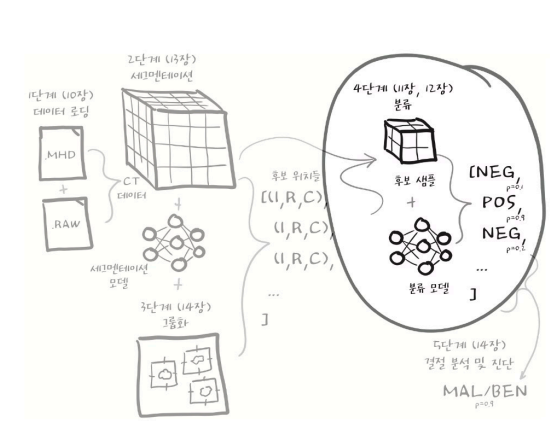

이 장의 주제인 4단계, 분류가 강조된 폐암 진단을 위한 엔드투엔트 프로젝트

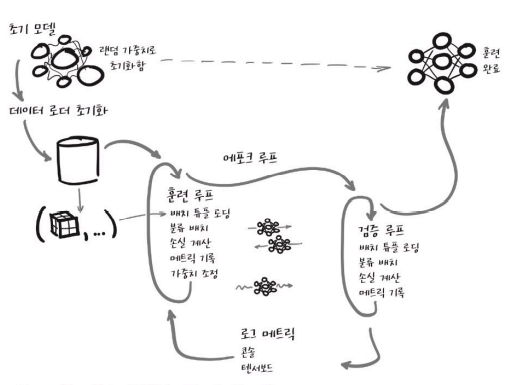

이번 11장에서 구현할 훈련 스크립트와 검증 스크립트

## 구현의 기본 구조

### 모델을 초기화하고 데이터를 로딩
### 어느 정도 임의로 선택한 에포크 수로 루프를 반복  
- LunaDataset이 반환한 훈련 데이터의 배치 루프를 돈다.
- 백그라운드에서 데이터로터 워커 프로세스는 적합한 배치를 읽어들인다.
- 배치를 분류 모델에 전달하여 결과를 얻는다.
- 추정 결과를 실측 데이터와 비교하여 손실을 계산한다.
- 임시 데이터 구조에 모델의 성능 메트릭을 기록한다.
- 오차 역전파로 모델 가중치를 조정한다.
- (훈련 루프와 유사하게) 검증 데이터 배치로 루프 반복
- (백그라운드 워커 프로세스에서) 검증 데이터 배치를 읽어들인다.
- 배치를 분류하고 손실을 계산한다.
- 모델이 검증 데이터에 대해 얼마나 잘 동작했는지를 기록한다.
- 매 에포크마다 진행 상황과 성능 정보를 출력한다.

1부와 11장의 또 다른 차이점이라면, 훈련 진척에 대한 다양한 __메트릭__을 수집한다는 점임  

단순한 메트릭 수집을 넘어 올바른 메트릭을 수집하는 것이 얼마나 중요한지에 대해서도 이야기할 것임  

이번 11장에서는 메트릭을 수집하기 위한 인프라 구조를 깔아놓음

그리고 이 구조를 통해 전체와 개별 클래스 단위로 손실값과 잘 분류된 샘플의 백분율을 수집하고 표시할 예정

## 11.2 애플리케이션의 메인 진입점
- 앞에서 진행한 훈련과의 구조적인 차이는 2부가 완전한 명령행 애플리케이션이라는 점
- 명령행 인자를 파싱하고 완전한 --help 옵션을 제공하며 여러 환경에서 쉽게 실행할 수 있음
- 이를 통해 주피터와 배시 셀에서 손쉽게 실행 가능



- 애플리케이션은 클래스로 구현하여 필요할 때 인스턴스로 만들어 실행
- 함수 호출이나 OS 레벨의 프로세스로 훈련을 구동할 수 있다면 함수 호출을 래핑하여 주피터 노트북에 넣을 수 있으므로, 코드를 쉽게 네이티브 CLI나 브라우저에서 호출 할 수 있는 장점이 있음

In [ ]:
import datetime

from util.util import importstr
from util.logconf import logging
log = logging.getLogger('nb')

In [ ]:
def run(app, *argv):
    argv = list(argv)
    argv.insert(0, '--num-workers=4')  
    # 4코어 8스레드 CPU 로 가정, 필요시 수정 가능
    log.info("Running: {}({!r}).main()".format(app, argv))
    
    app_cls = importstr(*app.rsplit('.', 1)) 
    # __import__보다 깔끔한 호출 방식
    app_cls(argv).main()
    
    log.info("Finished: {}.{!r}).main()".format(app, argv))

파일을 끝까지 살펴보면 애플리케이션 객체를 인스턴스로 만들고 main 메소드를 호출하는 표준 형태의 if main 코드를 볼 수 있음

In [ ]:
if __name__ == '__main__':
    LunaTrainingApp().main()

파일에서 처음의 애플리케이션 클래스를 보면 방금 호출한 두 함수 init 과 main을 볼 수 있음  

명령행 인자를 받으므로 애플리케이션 init 함수에서 표준 argparse 라이브러리를 사용  

초기화 함수에 커스텀 인자를 전달할 수 있고 그래야만 함

main 메소드는 애플리케이션의 핵심 로직을 위한 진입점임

In [ ]:
class LunaTrainingApp:
    def __init__(self, sys_argv=None):
        if sys_argv is None:
        # 인자 없이 호출하면 명령행으로부터 얻음
            sys_argv = sys.argv[1:]

        parser = argparse.ArgumentParser()
        parser.add_argument('--num-workers',
            help='Number of worker processes for background data loading',
            default=8,
            type=int,
        )
        parser.add_argument('--batch-size',
            help='Batch size to use for training',
            default=32,
            type=int,
        )
        # ... 63행
        self.cli_args = parser.parse_args(sys_argv)
        self.time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
        # 훈련 회차를 식별하기 위해 타임스탬프 사용
        
        # ... 137행
    def main(self):
        log.info("Starting {}, {}".format(type(self).__name__, self.cli_args))


이 구조는 매우 일반적이라 향후 다른 프로젝트에서 재사용 가능

## 11.3 사전 훈련 설정과 초기화
- 에포크 내의 각 배치를 순회하기에 앞서, 초기화가 필요
- 두 가지 작업을 해야함 (1. 모델과 옵티마이저의 초기화 / 2. Dataset과 DataLoader 인스턴스 초기화 )
- LunaDataset은 랜덤으로 선택한 샘플셋을 정의하여 훈련 에포크를 채워줄 것이고 DataLoader 인스턴스는 데이터셋으로부터 데이터를 읽는 작업을 수행하여 애플리케이션에 제공함
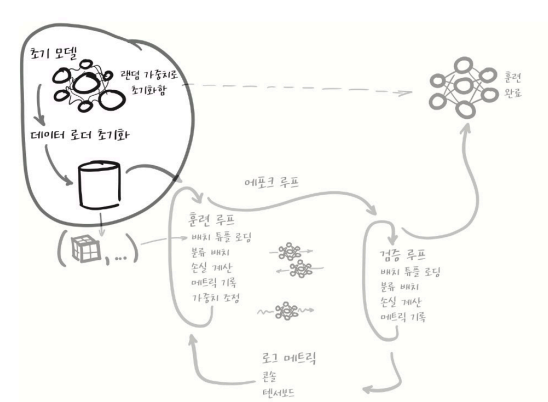

### 11.3.1 모델과 옵티마이저 초기화
- 이 절에서는 LunaModel 세부를 블랙박스처럼 생각함
- 시작 부분을 살펴볼 것임

In [ ]:
class LunaTrainingApp:
    def __init__(self, sys_argv=None):
        # ... 70행
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_cuda else "cpu")

        self.model = self.initModel()
        self.optimizer = self.initOptimizer()
        
    def initModel(self):
        model = LunaModel()
        if self.use_cuda:
            log.info("Using CUDA; {} devices.".format(torch.cuda.device_count()))
            if torch.cuda.device_count() > 1:
            # 복수개의 GPU 탐지
                model = nn.DataParallel(model)
                # 모델을 래핑
            model = model.to(self.device)
            # GPU에 모델 파라미터 전달
        return model

    def initOptimizer(self):
        return SGD(self.model.parameters(), lr=0.001, momentum=0.99)
        # return Adam(self.model.parameters())
        

훈련을 위해 두 개 이상의 GPU를 사용한다면 nn.DataParallel 클래스를 사용하여 모든 GPU에 작업을 분산해서 처리 후 파라미터를 다시 모아 조적 작업 재동기화하는 방식으로 진행

처음 시작하는 입장에서 SGD를 옵티마이저로 고르는 것은 안전한 선택 / 학습률 0.001이나 모멘텀 0.9도 안전한 선ㄴ택

학습률, 모멘텀, 신경망 규모 등 기타 유사한 설정을 체계적으로 바꿔가며 찾아가는 과정을 __하이퍼파라미터__ 탐색이라 부름

### 11.3.2 데이터 로더의 관리와 데이터 공급
- 앞서 10장에서 만든 LunaDataset 클래스는 우리가 확보한 거친 원본 데이터와 파이토치 빌딩 블럭을 위한 구조화된 텐서 사이의 가교 역할을 함
- 예를 들어 torch.nn.Conv3d는 5차원 입력(N, C, D, H, W)인 샘플 수와 샘플당 채널 수뿐만 아니라 깊이와 높이, 마지막 너비까지 입력값으로 줘야 함. CT의 3차원과는 완전히 다름
- 이전 장의 LunaDataset._getitem__에 있던 ct_t.unsqueeze(0)를 떠올릴지도 모름. 그 함수는 우리 데이터의 네 번째 차원인 '채널'을 제공 / CT 스캔은 단일한 밀도를 가지므로 채널 자원 크기는 1임
- 1부 내용을 되짚어보면, 단일 샘플에 대한 훈련이나 검증 작업 수행은 대두분의 플랫폼에서 이미 여러 샘플에 대한 병렬 계산을 지원하기 때문에 컴퓨터 자원을 비효율적으로 사용, 그러므로 이를 개선하기 위해서는 여러 샘플을 배치 튜플로 묶어 한 번에 처리될 수 있게 해야 함 / 5차원(N)을 동일한 배치 내에서 샘플을 구별하는 용도로 사용
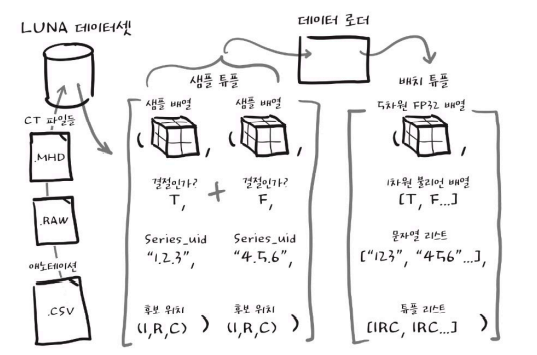

편리하게도, 우리는 배치를 직접 구현할 필요가 없음. 파이토치 DataLoader 클래스가 대신 구현해주기 때문

이미 CT 스캔을 파이토치 텐서로 바꾸기 위해 LunaDataset 클래스를 만들었으니 데이터셋을 데이터 로더에 연결하기만 하면 됨

In [ ]:
    def initTrainDl(self):
        train_ds = LunaDataset(
        # 커스텀 데이터셋
            val_stride=10,
            isValSet_bool=False,
        )

        batch_size = self.cli_args.batch_size
        if self.use_cuda:
            batch_size *= torch.cuda.device_count()

        train_dl = DataLoader(
        # 바로 사용하면 되는 클래스
            train_ds,
            batch_size=batch_size,
            # 알아서 배치로 나눈다
            num_workers=self.cli_args.num_workers,
            pin_memory=self.use_cuda,
            # 고정된 메모리 영역이 GPU 쪽으로 빠르게 전송됨
        )

        return train_dl

    
        # ... 137행
    def main(self):
        log.info("Starting {}, {}".format(type(self).__name__, self.cli_args))

        train_dl = self.initTrainDl()
        val_dl = self.initValDl() 
        # 검증 데이터 로더는 훈련 데이터 로더와 매우 유사

데이터 로더는 개별 샘플을 배치로 만들 뿐만 아니라, 별도의 프로세스와 공유 메모리를 사용한 병렬 코딩도 제공

데이터 로더 인스턴스를 만들 때 num_workers=...만 지정해주면 나머지는 알아서 처리되고, 각 워커 프로세스는 위의 그림처럼 배치를 만들어냄

isValSet_bool=True인 점을 빼면 validation_ds와 validation_dl 인스턴스는 서로 비슷함

그리고 코드에서 for batch_tup in self.train_dl: 처럼 루프를 돌 때 매번 Ct를 로드하고 샘플을 가져와 배치할 때까지 기다릴 필요가 없음.

이미 로딩이 끝난 batch_tup을 바로 사용하며 워커 프로세스는 다음 순회 시 사용하기 위한 또 다른 배치를 로드하기 위해 자동으로 헤제될 것임

파이토치의 데이터 로딩 기능을 사용하면 GPU 계산과 데이터 로딩을 동시에 진행하므로 대부분의 경우 프로젝트를 빠르게 실행할 수 있음


## 11.4 첫 번째 경로 신경망 설계

8장에서 사용한 신경망 설계를 기본으로 함

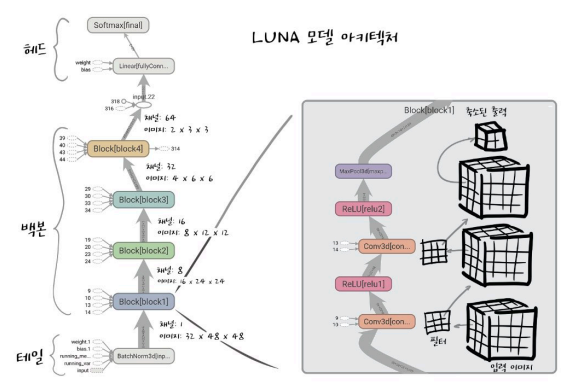

### 11.4.1 핵심 컨볼루션
- 분류 모델에서는 테일, 백본(혹은 바디), 헤드로 구성된 구조가 흔함
- 테일은 입력을 신경망에 넣기 전 처리 하는 과정을 담당 (이 책에서는 단순 배치 정규화 계층을 사용하지만 테일에 컨볼루션 층이 있는 경우도 있음, 테일에 있는 컨볼루션은 이미지 크기를 공격적으로 다운샘플링하기 위한 용도가 대부분, 우리 가진 이미지 이미 작으므로 다운샘플링 필요 없음)
- 백본은 여러 계층을 가지는데 일반적으로 연속된 블럭에 배치됨. 각 블럭은 동일한 세트의 계층을 가지며 블럭과 블럭을 거칠 때마다 필요한 입력 크기나 필터 수가 달라짐. 우리는 두 개의 3 * 3 컨볼루션과 하나의 활성화, 그리고 블록 끝에 맥스 풀링 연산이 이어진 블럭을 사용한다.

In [ ]:
class LunaBlock(nn.Module):
    def __init__(self, in_channels, conv_channels):
        super().__init__()

        self.conv1 = nn.Conv3d(
            in_channels, conv_channels, kernel_size=3, padding=1, bias=True,
        )
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(
            conv_channels, conv_channels, kernel_size=3, padding=1, bias=True,
        )
        self.relu2 = nn.ReLU(inplace=True)
        # relu 부분은 함수형 api호출로도 구현 가능함

        self.maxpool = nn.MaxPool3d(2, 2)

    def forward(self, input_batch):
        block_out = self.conv1(input_batch)
        block_out = self.relu1(block_out)
        block_out = self.conv2(block_out)
        block_out = self.relu2(block_out)

        return self.maxpool(block_out)

- 마지막으로 신경망의 헤드는 백본의 출력을 받아 원하는 출력 형태로 바꿈. 컨볼루션 신경망에서 이 작업은 중간 출력물을 평탄화하고 완전 연결 계층(fully connected layer)에 전달하는 역할을 하기도 함.

- 우리의 분류는 두 가지 뿐이므로 복잡하게 만들 필요가 없어 하나의 평탄화 계층만 사용
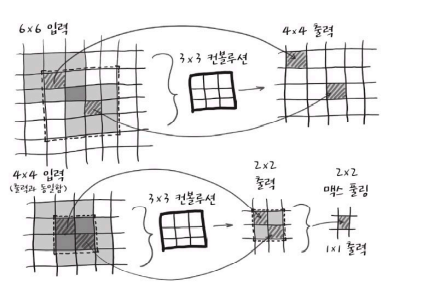

- 그림에서는 우리가 사용하는, 2차원으로 표현된 블럭의 컨볼루션을 살펴볼 수 있음(큰 이미지의 일부이므로 패딩은 무시)
- LunaModel 블럭의 컨볼루션 아키텍처. 두 개의 3 * 3 컨볼루션 뒤에 맥스 풀링이 있다. 마지막 픽셀은 6 * 6 수용필드를 가진다.

- 이 블럭에서는 3 * 3 * 3 컨볼루션 사용, 두 개의 겹겹이 쌓인 3 * 3 * 3 계층은 5 * 5 * 5 컨볼루션보다 더 적은 파라미터 가짐(계산도 더 빠름)
- 두 개의 쌓인 컨볼루션 출력은 2 * 2 * 2 맥스 풀링으로 들어감.
- 결론적으로 우리는 6 * 6 * 6 수용 필드로부터 8분의 7에 해당하는 데이터는 버리고 가장 큰 값을 가지는 한 개의 5 * 5 * 5필드 만듦

### 11.4.2 전체 모델

In [ ]:
class LunaModel(nn.Module):
    def __init__(self, in_channels=1, conv_channels=8):
        super().__init__()

        # 테일 | 전처리, 입력을 정규화
        self.tail_batchnorm = nn.BatchNorm3d(1)

        # 백본 | 데이터 32*48*48 연산 거치면서 2*3*3 됨
        self.block1 = LunaBlock(in_channels, conv_channels)
        self.block2 = LunaBlock(conv_channels, conv_channels * 2)
        self.block3 = LunaBlock(conv_channels * 2, conv_channels * 4)
        self.block4 = LunaBlock(conv_channels * 4, conv_channels * 8)

        # 헤드 | 백본의 출력을 받아 원하는 출력 형태로 바꿈 
        self.head_linear = nn.Linear(1152, 2)
        self.head_softmax = nn.Softmax(dim=1)